In [1]:
import pandas as pd
import numpy as np
import datetime
import re
import os
import boto3
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
#Copy Data From S3
s3 = boto3.client('s3')
s3.download_file('distribution-reliability-nlp', 
                 'We Energies 2016-2018 outage data_IncludesMI.xlsx', 
                 'We Energies 2016-2018 outage data_IncludesMI.xlsx')
s3.download_file('distribution-reliability-nlp', 
                 'WPS 2010-2018 Outage data.xlsx', 
                 'WPS 2010-2018 Outage data.xlsx')
s3.download_file('distribution-reliability-nlp', 
                 '2010-2017 UG5 MI & WI BASIC formatted..xlsx', 
                 '2010-2017 UG5 MI & WI BASIC formatted..xlsx')

In [3]:
#import We data
we_outages_1 = pd.read_excel('2010-2017 UG5 MI & WI BASIC formatted..xlsx')
we_outages_2 = pd.read_excel('We Energies 2016-2018 outage data_IncludesMI.xlsx')

In [4]:
#convert string to datetime
we_outages_2['outage_date'] = we_outages_2['outage_date'].map(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y %H:%M:%S'))

#keep only 2018 data
we_outages_2 = we_outages_2[we_outages_2['outage_date'] > datetime.datetime(2017,12,31,0,0)]

In [5]:
we_outages_2 = we_outages_2.rename(columns={'volt_code': 'Volt',
                                            'system_code': 'Sys',
                                            'storm_flag': 'Strm',
                                            'region': 'Region',
                                            'sc_area': 'Area',
                                            'service_cntr': 'SC',
                                            'substation_name': 'SS Location',
                                            'equip_cat': 'Repair Made',
                                            'weather_cond': 'Weather',
                                            'int_device_desc': 'Int Device',
                                            'open_code': 'Opn',
                                            'close_code': 'Cls',
                                            'phase_affected': 'PhAff',
                                            'phase_restored': 'PhRst',
                                            'restore_desc': 'How Rest',
                                            'med': 'med',
                                            'state': 'state',
                                            'outage_date': 'OutDat',
                                            'nbr_of_cstmr': 'CI',
                                            'minutes_cstmr_restored': 'CMI',
                                            'outage_duration': 'Cdur',
                                            'restored_kva': 'Ckva',
                                            'no_calls': 'Calls',
                                            'cause_category': 'Cause Cat',
                                            'specific_cause': 'Cause',
                                            'comment': 'Mobile Data Remarks'})

In [6]:
#append 2018 data to rest of data
we_outages = pd.concat([we_outages_1, we_outages_2])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


In [7]:
#import WPS data
wps_outages = pd.read_excel('WPS 2010-2018 Outage data.xlsx')

In [8]:
#seperate we subcategory names 
we_outages['we outage subcategory'] = we_outages['Cause'].str.split('- ', n=1, expand = True)[1]
we_outages['we outage subcategory'].head()

0    Conductor Connector
1                  Cable
2            Fallen Tree
3                  Cable
4    Conductor Connector
Name: we outage subcategory, dtype: object

In [9]:
def general_categories(category):
    '''
    this function translates the both we and wps outage subcategories to the general IEEECauses categories
    '''
    outage_cause = 'Unknown'
    if (category == 'C45 Dist Equip Fail_Arrestor' or
        category == 'C41 Dist Equip Fail_Conductor' or
        category == 'C75 Wire Down' or
        category == 'C76 Wire Down_Pri' or
        category == 'C77 Wire Down_Sec' or
        category == 'C43 Dist Equip Fail_Connector' or
        category == 'C47 Dist Equip Fail_Insulator' or
        category == 'C46 Dist Equip Fail_Blown Fuse' or
        category == 'C44 Dist Equip Fail_Cutout' or
        category == 'C46 Dist Equip Fail_Broken Fuse' or
        category == 'C80 Fuse' or
        category == 'C82 Fuse_Nuisance' or
        category == 'SCADA' or
        category == 'C42 Dist Equip Fail_Transformer' or
        category == 'C40 Dist Equip Fail' or
        category == 'C48 Dist Equip Fail_Other' or
        category == 'C96 Substation Equip Failure' or
        category == 'Automated SCADA Switch' or
        category == 'Auxiliary Transformer' or
        category == 'Bayonet Fuse' or
        category == 'Bushing' or
        category == 'Cable' or
        category == 'Circuit Breaker' or
        category == 'Conductor' or
        category == 'Connector' or
        category == 'Control Equipment' or
        category == 'Current Transformer' or
        category == 'Cutout (Blade)' or
        category == 'Cutout (Fused)' or 
        category == 'Electronic Recloser' or
        category == 'Fuse Link' or
        category == 'Galloping' or
        category == 'Hydraulic Recloser' or
        category == 'Insulator Dead-End' or
        category == 'Insulator Line Post' or
        category == 'Insulator Pin' or
        category == 'Insulink' or
        category == 'Isolation Disconnect' or
        category == 'Jumper' or
        category == 'Lightning/Surge Arrester' or
        category == 'Load Break' or
        category == 'Load Break Separable Connector' or
        category == 'Loop Feed Pad Mounted Transformer' or
        category == 'Meter' or
        category == 'Other' or
        category == 'Pole' or
        category == 'Pole Cross Arm' or
        category == 'Pole Mounted Dist. Transformer' or
        category == 'Polymeric Termination Riser Pole' or
        category == 'Potential/Voltage Transformer' or
        category == 'Pothead' or
        category == 'Power Fuse' or
        category == 'Power Transformer' or
        category == 'Radial or Open Point Pad Mounted Transformer' or
        category == 'Relay' or
        category == 'Slack' or
        category == 'Slapping' or
        category == 'Splice' or
        category == 'Step-Down/Conversion Transformer' or
        category == 'Switched Fuse Unit' or
        category == 'Vacuum Fault Interrupter' or
        category == 'Voltage Regulator' or
        category == 'Conductor/Cable Splice' or
        category == 'Conductor Connector' or
        category == 'Galloping Conductors' or
        category == 'LB Separable Insulated Connector' or
        category == 'Lightning or Surge Arrester' or
        category == 'Load Break Switch' or
        category == 'Riser Pole Polymeric Termination' or
        category == 'Slack Conductor' or
        category == 'Slapping Conductors'):
        outage_cause = 'Equipment'
    elif (category == 'C98 Planned Outage' or
          category == 'Construction' or
          category == 'Customer Request' or
          category == 'Load Shed' or
          category == 'Maintenance'):
        outage_cause = 'Planned'
    elif (category == 'C97 Transmission' or
        category == 'Loss of Transmission Source'):
        outage_cause = 'Power Supply'
    elif (category == 'C30 Human' or
        category == 'C33 Human Error_Contractor' or
        category == 'C70 Underground Dig In' or
        category == 'C71 Underground Dig In_Pri' or
        category == 'C72 Underground Dig In_Sec' or
        category == 'C73 Underground Dig In_Serv' or
        category == 'C91 Fire/Structure' or
        category == 'C50 Vehicle Accident' or
        category == 'C32 Human Error_Customer' or
        category == 'C32 Human Error_Other' or
        category == 'C30 Human Error' or
        category == 'Company Crew Dig-In' or
        category == 'Crane' or
        category == 'Customer Trouble' or
        category == 'Fire or Explosion' or
        category == 'Fire or Police Request' or
        category == 'Homeowner Dig-In' or
        category == 'Locating Dig-In' or
        category == 'Other' or
        category == 'Subcontractor Dig-In' or
        category == 'Third Party Contractor Dig-In' or
        category == 'Tree Trimmer' or
        category == 'Unknown Dig-In' or
        category == 'Vandalism' or
        category == 'Vehicle' or
        category == 'Other Foreign Contact'):
        outage_cause = 'Public'
    elif (category == 'C10 Tree_Growing_Into_Primary' or
        category == 'C11 Tree_Not_Growing_Into_Primary' or
        category == 'C12 Tree_Secondary_Service' or
         category == 'Ash Fallen Limb' or
          category == 'Ash Fallen Tree' or
          category == 'Fallen Limb' or
          category == 'Fallen Tree' or
          category == 'Other' or
          category == 'Tree Growth' or
          category == 'Vine Growth' or
          category == 'See Reason'):
        outage_cause = 'Vegetation'
    elif (category == 'C95 Major Storm' or
        category == 'C21 Snow/Ice Loading' or 
        category == 'C20 Weather' or 
        category == 'Ice' or 
          category == 'Rain' or
          category == 'Snow' or 
          category == 'Wind' or 
          category == 'C22 Lightning' or
          category == 'Lightning'):
        outage_cause = 'Weather'
    elif (category == 'C60 Animals' or
        category == 'C62 Animals_Ground' or
        category == 'C61 Animals_Bird' or 
         category == 'Bird Excrement' or
          category == 'Bird Nest' or 
          category == 'Crane' or
          category == 'Crow' or
          category == 'Mouse or Rat' or
          category == 'Bird' or
          category == 'Pelican' or
          category == 'Perching Birds' or
          category == 'Raccoon' or
          category == 'Raptor' or
          category == 'See Comments' or
          category == 'Squirrel' or
          category == 'Turkey' or
          category == 'Unknown' or
          category == 'Waterfowl'):
        outage_cause = 'Wildlife'
    elif (category == 'C90 Unknown/Other' or 
          category == 'Unknown'):
        outage_cause = 'Unknown'
    elif (category == 'C31 Human Error_Employee' or
          category == 'C81 Fuse_Inadequate Coord' or
          category == 'C83 Fuse_Overload' or 
          category == 'C83 Fuse_Overloaded' or
          category == 'C84 Reclosure_Overload' or
          category == 'C84 Reclosure_Overloaded' or
         category == 'AMR Unknown' or
          category == 'Construction' or
          category == 'Contamination' or
          category == 'Corrosion' or
          category == 'Field Personnel Error' or
          category == 'Maintenance Error' or
          category == 'Operating Error' or
          category == 'Over into Underbuilt' or
          category == 'Overload' or
          category == 'Protection Error' or
          category == 'See Comments' or
          category == 'Wrong Fuse Size Error' or
          category == 'Construction Error'):
        outage_cause = 'Other'
    elif (category == 'C' or
          category == 'C49 Cust Equipment Failure' or
          category == 'C92 Disconnect/Reconnect' or
          category == 'C94 No Outage Comm Co Facility' or
          category == 'C99 No Outage' or
          category == 'Switch_Operation'):
        outage_cause = 'Not Reportable'

    return outage_cause

In [10]:
def subcategory_cause(sub_catageory, company):
    '''
    this function convert the sub category outage causes to a new subcategory 
    for both comapnies.
    '''
    sub_cause = ''
    if company == 'WPS':
        if sub_catageory == 'C45 Dist Equip Fail_Arrestor':
            sub_cause = 'Arrester'
        elif (sub_catageory == 'C41 Dist Equip Fail_Conductor' or
            sub_catageory == 'C75 Wire Down' or 
            sub_catageory == 'C76 Wire Down_Pri' or
            sub_catageory == 'C77 Wire Down_Sec' or
             sub_catageory == 'C78 Wire Down_Serv'): 
                sub_cause = 'Connector/Splice'
        elif sub_catageory == 'C47 Dist Equip Fail_Insulator':
            sub_cause = 'Insulator'
        elif (sub_catageory == 'C46 Dist Equip Fail_Blown Fuse' or
            sub_catageory == 'C44 Dist Equip Fail_Cutout' or
            sub_catageory == 'C46 Dist Equip Fail_Broken Fuse' or
            sub_catageory == 'C80 Fuse' or
            sub_catageory == 'C82 Fuse_Nuisance'):
                sub_cause = 'Simple Interrupting Device'
        elif sub_catageory == 'SCADA':
            sub_cause = 'Switching Device'
        elif sub_catageory == 'C42 Dist Equip Fail_Transformer':
            sub_cause = 'Transformer'
        elif (sub_catageory == 'C40 Dist Equip Fail' or
            sub_catageory == 'C48 Dist Equip Fail_Other' or
            sub_catageory == 'C96 Substation Equip Failure'):
                sub_cause = 'Other'
        elif sub_catageory == 'C22 Lightning':
            sub_cause = 'Lightning'
        elif sub_catageory == 'C98 Planned Outage':
            sub_cause = 'New Construction'
        elif sub_catageory == 'C97 Transmission':
            sub_cause = 'Transmission'
        elif (sub_catageory == 'C30 Human' or 
            sub_catageory == 'C33 Human Error_Contractor' or 
            sub_catageory == 'C70 Underground Dig In' or
            sub_catageory == 'C71 Underground Dig In_Pri' or
            sub_catageory == 'C72 Underground Dig In_Sec' or
            sub_catageory == 'C73 Underground Dig In_Serv'):
                sub_cause = 'Dig-In'
        elif sub_catageory == 'C91 Fire/Structure':
            sub_cause = 'Fire/Police'
        elif sub_catageory == 'C50 Vehicle Accident':
            sub_cause = 'Foreign Object'
        elif (sub_catageory == 'C32 Human Error_Customer' or
            sub_catageory == 'C32 Human Error_Other' or
            sub_catageory == 'C30 Human Error'):
                sub_cause = 'Other'
        elif sub_catageory == 'C10 Tree_Growing_Into_Primary':
            sub_cause = 'In Clearance Zone (ROW)'
        elif sub_catageory == 'C11 Tree_Not_Growing_Into_Primary':
            sub_cause = 'Out Clearance Zone (ROW)'
        elif sub_catageory == 'C12 Tree_Secondary_Service':
            sub_cause = 'Other'
        elif (sub_catageory == 'C95 Major Storm' or
            sub_catageory == 'C21 Snow/Ice Loading'):
            sub_cause = 'Precipitation'
        elif sub_catageory == 'C20 Weather':
            sub_cause = 'Other'
        elif (sub_catageory == 'C60 Animals' or
            sub_catageory == 'C62 Animals_Ground'):
                sub_cause = 'Mammal'
        elif sub_catageory == 'C61 Animals_Bird':
            sub_cause = 'Bird'
        elif (sub_catageory == 'C31 Human Error_Employee' or
            sub_catageory == 'C81 Fuse_Inadequate Coord'):
                sub_cause = 'Utility Error'
        elif (sub_catageory == 'C83 Fuse_Overload' or 
            sub_catageory == 'C83 Fuse_Overloaded' or 
            sub_catageory == 'C84 Reclosure_Overload' or
            sub_catageory == 'C84 Reclosure_Overloaded'):
                sub_cause = 'Other'
    elif company == 'We':
        if sub_catageory == 'Lightning/Surge Arrester':
            sub_cause = 'Arrester'
        elif (sub_catageory == 'Cable' or 
            sub_catageory == 'Conductor' or 
            sub_catageory == 'Galloping' or 
            sub_catageory == 'Jumper' or 
            sub_catageory == 'Slapping' or
            sub_catageory == 'Slack'):
                sub_cause = 'Conductor/Cable'
        elif (sub_catageory == 'Connector' or 
            sub_catageory == 'Insulink' or
            sub_catageory == 'Splice'):
                sub_cause = 'Connector/Splice'
        elif (sub_catageory == 'Control Equipment' or 
            sub_catageory == 'Meter' or
            sub_catageory == 'Relay'):
                sub_casue = 'Controls'
        elif (sub_catageory == 'Bushing' or 
            sub_catageory == 'Insulator Dead-End' or
            sub_catageory == 'Insulator Line Post' or
            sub_catageory == 'Insulator Pin'):
                sub_cause = 'Insulator'
        elif (sub_catageory == 'Load Break Separable Connector' or 
            sub_catageory == 'Polymeric Termination Riser Pole' or
            sub_catageory == 'Pothead'):
                sub_cause = 'Elbows / Terminators'
        elif (sub_catageory == 'Bayonet Fuse' or 
            sub_catageory == 'Cutout (Fused)' or
            sub_catageory == 'Fuse Link' or
            sub_catageory == 'Power Fuse' or
            sub_catageory == 'Switched Fuse Unit (SFU)' or
            sub_catageory == 'Vacuum Fault Interrupter (VFI)' or
            sub_catageory == 'Hydraulic Recloser'):
                sub_cause = 'Simple Interrupting Device'
        elif (sub_catageory == 'Circuit Breaker' or
            sub_catageory == 'Electronic Recloser'):
                sub_cause = 'Programmable Interrupting Device'
        elif (sub_catageory == 'Pole' or
            sub_catageory == 'Pole Cross Arm'):
                sub_cause = 'Structure/Support'
        elif (sub_catageory == 'Cutout (Blade)' or
            sub_catageory == 'Isolation Disconnect' or
            sub_catageory == 'Load Break' or
            sub_catageory == 'Automated SCADA Switch'):
                sub_cause = 'Switching Device'
        elif (sub_catageory == 'Auxiliary Transformer' or
            sub_catageory == 'Current Transformer' or 
            sub_catageory == 'Loop Feed Pad Mounted Transformer' or
            sub_catageory == 'Pole Mounted Dist. Transformer' or
            sub_catageory == 'Radial or Open Point Pad Mounted Transformer' or
            sub_catageory == 'Potential/Voltage Transformer' or
            sub_catageory == 'Power Transformer' or
            sub_catageory == 'Step-Down/Conversion Transformer' or
            sub_catageory == 'Potential/Voltage Transformer'):
                sub_cause = 'Transformer'
        elif (sub_catageory == 'Other' or
            sub_catageory == 'Voltage Regulator'):
                sub_cause = 'Other'
        elif sub_catageory == 'Lightning':
            sub_casue = 'Lightning'
        elif sub_catageory == 'Construction':
            sub_cause = 'New Construction'
        elif sub_catageory == 'Maintenance':
            sub_cause = 'Maintenance'
        elif sub_catageory == 'Customer Request':
            sub_cause = 'Customer Request'
        elif sub_catageory == 'Load Shed':
            sub_cause = 'Other'
        elif sub_catageory == 'Loss of Transmission Source':
            sub_cause = 'Transmission'
        elif (sub_catageory == 'Company Crew Dig-In' or
            sub_catageory == 'Homeowner Dig-In' or
            sub_catageory == 'Locating Dig-In' or
            sub_catageory == 'Subcontractor Dig-In' or
            sub_catageory == 'Third Party Contractor Dig-In' or
            sub_catageory == 'Unknown Dig-In'):
                sub_cause = 'Dig-In'
        elif (sub_catageory == 'Fire or Police Request' or 
            sub_catageory == 'Fire or Explosion'):
                sub_cause = 'Fire/Police'
        elif (sub_catageory == 'Tree Trimmer' or
            sub_catageory == 'Crane' or
            sub_catageory == 'Other' or
            sub_catageory == 'Vehicle'):
                sub_cause = 'Foreign Object'
        elif (sub_catageory == 'Customer Trouble' or 
            sub_catageory == 'Vandalism'):
                sub_cause = 'Other'
        elif (sub_catageory == 'Fallen Limb' or
            sub_catageory == 'Tree Growth' or
            sub_catageory == 'Ash Fallen Limb'):
                sub_cause = 'In Clearance Zone (ROW)'
        elif (sub_catageory == 'Fallen Tree' or
            sub_catageory == 'Ash Fallen Tree'):
                sub_cause = 'Out Clearance Zone (ROW)'
        elif (sub_catageory == 'Vine Growth' or
            sub_catageory == 'Other'):
                sub_cause = 'Other'
        elif (sub_catageory == 'Rain' or 
            sub_catageory == 'Snow'):
                sub_cause = 'Precipitation'
        elif sub_catageory == 'Ice':
            sub_cause = 'Ice'
        elif sub_catageory == 'Wind':
            sub_cause = 'Wind'
        elif (sub_catageory == 'Mouse or Rat' or
            sub_catageory == 'Raccoon' or 
            sub_catageory == 'Squirrel'):
                sub_cause = 'Mammal'
        elif (sub_catageory == 'Bird Excrement' or
            sub_catageory == 'Bird Nest' or
            sub_catageory == 'Crane' or
            sub_catageory == 'Crow' or
            sub_catageory == 'Pelican' or
            sub_catageory == 'Perching Birds' or
            sub_catageory == 'Raptor' or
            sub_catageory == 'Turkey' or
            sub_catageory == 'Waterfowl'):
                sub_cause = 'Bird'
        elif (sub_catageory == 'See Comments' or
            sub_catageory == 'Unknown'):
                sub_cause = 'Other'
        elif sub_catageory == 'Unknown':
            sub_cause = 'No Specific Cause Found'
        elif (sub_catageory == 'Field Personnel Error' or
            sub_catageory == 'Maintenance Error' or
            sub_catageory == 'Operating Error' or
            sub_catageory == 'Protection Error' or
            sub_catageory == 'Construction' or
            sub_catageory == 'Wrong Fuse Size Error'):
                sub_cause = 'Utility Error'
        elif (sub_catageory == 'AMR Unknown' or
            sub_catageory == 'Contamination' or
            sub_catageory == 'Corrosion' or
            sub_catageory == 'See Comments' or
            sub_catageory == 'Over into Underbuilt' or
            sub_catageory == 'Overload'):
                sub_cause = 'Other'

    return sub_cause

In [11]:
#convert wps outage categoies to IEEECauses categories
wps_outages['outage category'] = wps_outages['cause_code'].apply(general_categories)
#create sub categoies
wps_outages['outage subcategory'] = wps_outages['cause_code'].apply(subcategory_cause, args=(['WPS']))
#view data
wps_outages.head()

,Event,Outage,Utility,State,Agency,DGroup,feeder,ElectricLocation,CauseLocation,EventType,...,TimeBands,IEEECauses,PieChartCauses,%Outages,%num_cust,%CustomerMinutes,Region,Balloon,outage category,outage subcategory
0,E000151448,1,WPS,WI,WAU,WAU_E,MAV 242,:9529062:2707 3R13,2707 3r19,FUSE,...,8 hr,Public,Human,E000151448,7,1596.0,Western,NaN,Public,Foreign Object
1,E000151449,1,WPS,WI,GB,GB_E,HOW 242,:90796810:130 CC67,NaN,XFMR_DIST_UG,...,3 Hr,Planned Outage,Planned Outage,E000151449,3,213.0,Eastern,NaN,Planned,New Construction
2,E000151455,1,WPS,WI,RHI,RHI_E,HOD 241,:3709 9L28:23253446,3709 9L28,PWROUT,...,1 Hr,Public,Human,E000151455,1,14.0,Northern,NaN,Public,Fire/Police
3,E000151456,1,WPS,WI,RHI,RHI_E,HOD 241,:3609 4L9:23169628,3609 4L79,PWROUT,...,3 Hr,Unknown,Miscellaneous,E000151456,1,81.0,Northern,Balloon,Unknown,
4,E000151459,1,WPS,WI,CHI,CHI_E,GRA 241,:53 MM48:2759139,NaN,PWROUT,...,3 Hr,Vegetation,Fallen Trees,E000151459,1,136.0,Eastern,NaN,Vegetation,Other


In [12]:
#convert we outage categoies to IEEECauses categories
we_outages['outage category'] = we_outages['we outage subcategory'].apply(general_categories)
#create subcategory
we_outages['outage subcategory'] = we_outages['we outage subcategory'].apply(subcategory_cause, args=(['We']))
#view data
we_outages.head()

,Area,BegHr,C Elemnt,CI,CMI,Calls,Cause,Cause Cat,Cdur,Ckva,...,outage_reason,outage_type,prepared_by_initials,state,total_accounts,week_of_year,year,we outage subcategory,outage category,outage subcategory
0,IR,10.0,ARA51,4,240,1.0,Equip. - Conductor Connector,Equipment,60,200,...,NaN,NaN,NaN,MI,NaN,NaN,NaN,Conductor Connector,Equipment,
1,IR,23.0,BLV2,1,58,1.0,Equip. - Cable,Equipment,58,10,...,NaN,NaN,NaN,MI,NaN,NaN,NaN,Cable,Equipment,Conductor/Cable
2,IR,11.0,SBH3,1,85,1.0,Vegetation - Fallen Tree,Vegetation,85,15,...,NaN,NaN,NaN,MI,NaN,NaN,NaN,Fallen Tree,Vegetation,Out Clearance Zone (ROW)
3,IR,12.0,BAS53,1,385,1.0,Equip. - Cable,Equipment,385,150,...,NaN,NaN,NaN,MI,NaN,NaN,NaN,Cable,Equipment,Conductor/Cable
4,IR,12.0,WSM2,1,53,1.0,Equip. - Conductor Connector,Equipment,53,0,...,NaN,NaN,NaN,MI,NaN,NaN,NaN,Conductor Connector,Equipment,


In [13]:
#Keeping what is needed and useful
we_cat_var = ['Volt', 'Sys', 'Strm', 'Area', 'SC', 'SS Location', 'Repair Made', 'Weather',
              'Int Device', 'Opn', 'Cls', 'PhAff', 'How Rest', 'med', 'state']

wps_cat_var = ['State', 'Agency', 'DGroup', 'feeder', 'EventType',  'phase', 'WeatherCode',
               'WeatherLevel', 'FollowUpReqReport', 'major_storm', 'Storm Flag', 
               'OnCall', 'Working']

we_date_var = ['OutDat']

wps_date_var = ['OffTime']

we_num_var = ['CI', 'CMI', 'Cdur', 'Ckva', 'Calls']

wps_num_var = ['num_cust', 'outage_duration', 'CustomerMinutes']

we_text_var = ['Mobile Data Remarks']

wps_text_var = ['ClosureRemarks']

out_vars = ['outage category', 'outage subcategory']

we_outages = we_outages[we_cat_var + we_date_var + we_num_var + we_text_var + out_vars]
wps_outages = wps_outages[wps_cat_var + wps_date_var + wps_num_var + wps_text_var + out_vars]

# Clean Comment Info

In [14]:
#select text and outcome
we_text_out = we_outages[out_vars + we_text_var]
wps_text_out = wps_outages[out_vars + wps_text_var]
#label which outage came from which company
we_text_out['Company'] = 'WE'
wps_text_out['Company'] = 'WPS'
#rename comment column in wps data
wps_text_out = wps_text_out.rename({'ClosureRemarks': 'Mobile Data Remarks'}, axis='columns')
wps_text_out.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,outage category,outage subcategory,Mobile Data Remarks,Company
0,Public,Foreign Object,NaN,WPS
1,Planned,New Construction,NaN,WPS
2,Public,Fire/Police,NaN,WPS
3,Unknown,,metalic balloon in wires/xfrmer,WPS
4,Vegetation,Other,NaN,WPS


In [15]:
#combine we and wps data
all_text_out = pd.concat([we_text_out, wps_text_out])
#remove missings
all_text_out = all_text_out.dropna()
all_text_out.shape

(149460, 4)

In [16]:
#make sure comments are strings
all_text_out['Mobile Data Remarks'] = all_text_out['Mobile Data Remarks'].astype(str)

#looking at what we have
all_text_out.head()

,outage category,outage subcategory,Mobile Data Remarks,Company
0,Equipment,,ON LtOut TRBL SAYS {OTHER SEE COMMENTS},WE
1,Equipment,Conductor/Cable,ON LtOut TRBL SAYS {ONE LEG OF URD IS DEAD. CU...,WE
2,Vegetation,Out Clearance Zone (ROW),ON HAZ TRBL SAYS {REMOVED TREE FROM LINE NEARP...,WE
3,Equipment,Conductor/Cable,ON LtOut TRBL SAYS {REPAIRED BAD PRIMARY URD C...,WE
4,Equipment,,ON LtOut TRBL SAYS {BAD CONNECTOR ON CUST. SER...,WE


In [17]:
def clean_comments(text):
    '''
    This function will remove the common text before the comments
    '''
    pattern_1 = r"ON LtOut WE\d{4,5} SAYS\s"
    regex_1 = re.sub(pattern_1, '', text)
    pattern_2 = r"ON LtOut TRBL SAYS"
    regex_2 = re.sub(pattern_2, '', regex_1)
    pattern_3 = r"ON HAZ TRBL SAYS"
    regex_3 = re.sub(pattern_3, '', regex_2)
    new_text = regex_3.replace('@', 'at')
    pattern_4 = r"[^a-zA-Z0-9]+"
    regex_4 = re.sub(pattern_4, ' ', new_text)
    pattern_5 = r"ON LtOut W\d{4,5} SAYS\s"
    regex_5 = re.sub(pattern_5, '', regex_4)
    pattern_6 = r"ON LtOut W\d{4,5} SAYS\s"
    regex_6 = re.sub(pattern_6, '', regex_5)
    pattern_7 = r"ON HAZ W\d{4,5} SAYS\s"
    regex_7 = re.sub(pattern_7, '', regex_6)
    pattern_8 = r"ON HAZ WE\d{4,5} SAYS\s"
    regex_8 = re.sub(pattern_8, '', regex_7)
    pattern_9 = r"OTHER SEE COMMENTS\s"
    regex_9 = re.sub(pattern_9, '', regex_8)
    
    return regex_9


all_text_out['Mobile Data Remarks'] = all_text_out['Mobile Data Remarks'].apply(clean_comments)
all_text_out['Mobile Data Remarks'].head()

0                                                     
1     ONE LEG OF URD IS DEAD CUSTOMER SAID WE CAN F...
2     REMOVED TREE FROM LINE NEARPOLE63 1688 AND CL...
3     REPAIRED BAD PRIMARY URD CABLES CABLE REPAIRE...
4     BAD CONNECTOR ON CUST SERV POLE CONN REPLACED...
Name: Mobile Data Remarks, dtype: object

In [18]:
#remove 'other see comments'
all_text_out = all_text_out[all_text_out['Mobile Data Remarks'] != ' ']
all_text_out['Mobile Data Remarks'] = all_text_out['Mobile Data Remarks'].map(lambda x: x.lower())
all_text_out.head()

,outage category,outage subcategory,Mobile Data Remarks,Company
1,Equipment,Conductor/Cable,one leg of urd is dead customer said we can f...,WE
2,Vegetation,Out Clearance Zone (ROW),removed tree from line nearpole63 1688 and cl...,WE
3,Equipment,Conductor/Cable,repaired bad primary urd cables cable repaire...,WE
4,Equipment,,bad connector on cust serv pole conn replaced...,WE
6,Equipment,Simple Interrupting Device,replaced broken cutout and installed wlp taq ...,WE


In [19]:
#write the cleaned data to a csv file
all_text_out.to_csv('We_WPS_comments_categories.csv', index = False)

# Clean Outcome Variable

In [20]:
#convert outcome to category type
all_text_out['outage category'] = all_text_out['outage category'].astype('category')
#convert category type to number
all_text_out['outage category number'] = all_text_out['outage category'].cat.codes
all_text_out.head()

,outage category,outage subcategory,Mobile Data Remarks,Company,outage category number
1,Equipment,Conductor/Cable,one leg of urd is dead customer said we can f...,WE,0
2,Vegetation,Out Clearance Zone (ROW),removed tree from line nearpole63 1688 and cl...,WE,7
3,Equipment,Conductor/Cable,repaired bad primary urd cables cable repaire...,WE,0
4,Equipment,,bad connector on cust serv pole conn replaced...,WE,0
6,Equipment,Simple Interrupting Device,replaced broken cutout and installed wlp taq ...,WE,0


In [21]:
#make decoder table
decoder = pd.DataFrame({'Word': all_text_out['outage category'].unique(),
                        'Number': all_text_out['outage category number'].unique()})
#save decoder
decoder.to_csv('decoder.csv')

# Clean We Non-Text

In [22]:
#filling missing category variables
blank_vars = ['Strm', 'Repair Made',         'Weather', 'med']
blank_fill = ['NS',    'OTHER SEE COMMENTS', 'Calm',     'N']

i = 0
while i <= 3:
    we_outages[blank_vars[i]] = we_outages[blank_vars[i]].fillna(blank_fill[i])
    i += 1

In [23]:
#creating date varialbes 
we_outages_date = we_outages[we_date_var]

#convert string date time to python datetime
#we_outages_date['date'] = we_outages_date['OutDat'].map(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y %H:%M:%S'))

#create needed variables
we_outages_date['hour'] = we_outages_date['OutDat'].map(lambda x: x.hour).astype(str)
we_outages_date['week'] = we_outages_date['OutDat'].map(lambda x: x.week).astype(str)
we_outages_date['year'] = we_outages_date['OutDat'].map(lambda x: x.year).astype(str)

#keep only new varialbes
we_outages_date = we_outages_date[['hour', 'week', 'year']]

#convert new date variables to dummies
we_outages_date = pd.get_dummies(we_outages_date)
we_outages_date.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

,hour_0,hour_1,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,...,week_9,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [24]:
#fix a few vars
to_replace =   ['OS', 'OM', 'DB', 'CM']
replace_fill = ['OH', 'OH', 'UG', 'UG']

i = 0
while i <= 3:
    we_outages['Sys'] = we_outages.replace(to_replace[i], replace_fill[i])
    i += 1

In [25]:
#creating dummies from categorgical vars
we_outages_cat = we_outages[we_cat_var]

#create dummies
we_outages_cat = pd.get_dummies(we_outages_cat)
we_outages_cat.head()

,Volt_D,Volt_E,Volt_F,Volt_H,Volt_J,Volt_M,Volt_R,Volt_SD,Volt_TV,Volt_US,...,How Rest_RE-ENERGIZE STA SOURCE,How Rest_REPAIR CIRCUIT,How Rest_REPAIR/REPLACE WIRE/EQUIP,How Rest_REPLACE DEFECT EQUIP,How Rest_REPLACE FUSE,How Rest_SOURCE - NO CUSTOMERS,med_N,med_Y,state_MI,state_WI
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,1,0


[Text(0.5, 0, 'CI'),
 Text(1.5, 0, 'CMI'),
 Text(2.5, 0, 'Cdur'),
 Text(3.5, 0, 'Ckva'),
 Text(4.5, 0, 'Calls')]

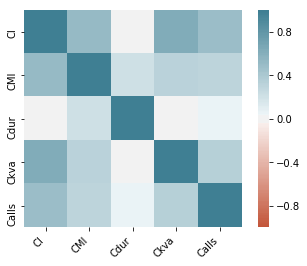

In [26]:
#see how much correlation there is between the numberic variables
corr = we_outages[we_num_var].corr()
ax = sns.heatmap(corr, 
                vmin=-1, vmax=1, center=0,
                cmap=sns.diverging_palette(20, 220, n=200),
                square=True)

ax.set_xticklabels(ax.get_xticklabels(),
                    rotation=45,
                    horizontalalignment='right')

In [27]:
#normilize all numeric data
we_outages_num = we_outages[we_num_var]

mean = we_outages_num.mean(axis=0)
std = we_outages_num.std(axis=0)

we_outages_num = (we_outages_num - mean)/std

In [28]:
#save off mean and std dev for prod cleaning
we_normalize = pd.DataFrame({'Mean': mean,
                            'Standard Deviation': std})
we_normalize.to_csv('We_normalize.csv', index = False)

In [29]:
#extract outcome variables
we_outages_out = we_outages[['outage category', 'outage subcategory']]

In [30]:
#gather all of the data
we_outages_cleaned = we_outages_cat.join([we_outages_num,
                                          we_outages_date,
                                            we_outages_out])
#remove missings
we_outages_cleaned = we_outages_cleaned.dropna()

we_outages_cleaned.head()

,Volt_D,Volt_E,Volt_F,Volt_H,Volt_J,Volt_M,Volt_R,Volt_SD,Volt_TV,Volt_US,...,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,outage category,outage subcategory
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Equipment,
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,Equipment,Conductor/Cable
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,Vegetation,Out Clearance Zone (ROW)
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Equipment,Conductor/Cable
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,Equipment,


In [31]:
#export cleaned data
we_outages_cleaned.to_csv('We_Cleaned.csv', index = False)

# Clean WPS Non-Text Data

In [32]:
def fix_weather(df, weather_fix, weather_help):
    '''
    This function fills in blanks in one variable using info in another
    '''
    if df[weather_fix] == float('NaN'):
        if df[weather_help] == 'L0 Normal':
            return '10 Clear'
        elif df[weather_help] == 'L3 Large':
            return '23 Adverse Weather'
        elif df[weather_help] == 'L1-L2 Sm-Med' or df[weather_help] == 'C4 Major' :
            return '20 Wind'
        
wps_outages['WeatherCode'] = wps_outages.apply(fix_weather, args=(['WeatherCode', 'WeatherLevel']), axis=1)

In [33]:
#extract substation info from feeder
wps_outages['substation'] = wps_outages['feeder'].map(lambda x: str(x)[:3])
wps_outages['substation'].unique()

array(['MAV', 'HOW', 'HOD', 'GRA', 'EWA', 'GLW', 'HI8', 'MTN', 'DAF',
       'LSD', 'SIS', 'HCR', 'OKY', 'TDR', 'PIN', '7TH', 'VEN', 'MEN',
       'HOO', 'VLP', 'WEM', 'WET', 'HIP', 'MSN', 'EGH', 'SUL', 'SIC',
       'AVN', 'SNZ', 'CRI', 'SOT', 'ROD', 'SBY', 'ALA', 'LIS', 'AUS',
       'MCR', 'GLR', 'MRP', 'HRR', 'WMK', 'CRB', 'JAS', 'RLD', 'CLK',
       'SHS', 'NPT', 'DUR', 'SGM', 'MGA', 'SAE', 'KEL', 'SMO', 'WAV',
       'HIV', 'BAT', 'OCO', 'RSR', 'EAV', 'KRN', 'STD', 'BLN', 'PBL',
       'SRD', 'EST', 'MEL', 'A12', 'SPT', 'EOD', 'TOW', 'GOS', 'BRU',
       'MHS', 'BDN', 'OSH', 'CSL', 'A30', 'KEV', 'nan', 'DYK', 'MIT',
       'THL', 'ANO', 'BNS', 'INS', 'LUX', 'MAD', 'GON', 'SOI', 'PLO',
       '7ST', 'ASH', 'HES', 'WPA', 'PAV', 'ONT', 'MAI', 'EAK', 'NS2',
       'TOR', 'POU', 'WSU', 'LEA', 'OAS', 'NOU', 'RML', 'BES', 'SUV',
       'GNF', 'RYN', 'UGB', 'ROO', '12A', '30A', 'MEM', '2NS', 'WDM',
       'PUL', 'VBS', 'AMB', '0', 'XXX', 'GUR', 'TOK', 'TMK'], dtype=object)

In [34]:
wps_outages[wps_outages['Agency'] != wps_outages['DGroup'].map(lambda x: str(x).split('_')[0])].shape

(0, 21)

In [35]:
#filling missing category variables
blank_vars = ['phase', 'FollowUpReqReport', 'Storm Flag', 'OnCall', 'Working']
blank_fill = ['NA',    'No',                'NS',         'No',     'No']

i = 0
while i <= 4:
    wps_outages[blank_vars[i]] = wps_outages[blank_vars[i]].fillna(blank_fill[i])
    i += 1

In [36]:
#creating date varialbes 
wps_outages_date = wps_outages[wps_date_var]

#create needed variables
wps_outages_date['hour'] = wps_outages_date['OffTime'].map(lambda x: x.hour).astype(str)
wps_outages_date['week'] = wps_outages_date['OffTime'].map(lambda x: x.week).astype(str)
wps_outages_date['year'] = wps_outages_date['OffTime'].map(lambda x: x.year).astype(str)

#keep only new varialbes
wps_outages_date = wps_outages_date[['hour', 'week', 'year']]

#convert new date variables to dummies
wps_outages_date = pd.get_dummies(wps_outages_date)
wps_outages_date.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

,hour_0,hour_1,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,...,week_9,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [37]:
#creating dummies from categorgical vars
wps_outages_cat = wps_outages[wps_cat_var]

#drop unwanted columns
wps_outages_cat = wps_outages_cat.drop(columns=['feeder', 'DGroup', 'WeatherLevel'])

#create dummies
wps_outages_cat = pd.get_dummies(wps_outages_cat)
wps_outages_cat.head()

,State_MI,State_WI,Agency_ANT,Agency_CHI,Agency_ER,Agency_GB,Agency_KEW,Agency_MER,Agency_MIN,Agency_MM,...,major_storm_NO,major_storm_YES,Storm Flag_EE,Storm Flag_MJ,Storm Flag_MN,Storm Flag_NS,OnCall_No,OnCall_Yes,Working_No,Working_Yes
0,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,1,0,1,0
1,0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,0,1,1,0,1,0
2,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,1,0,1,0
3,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,1,0,1,0
4,0,1,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,1,0,1,0


[Text(0.5, 0, 'num_cust'),
 Text(1.5, 0, 'outage_duration'),
 Text(2.5, 0, 'CustomerMinutes')]

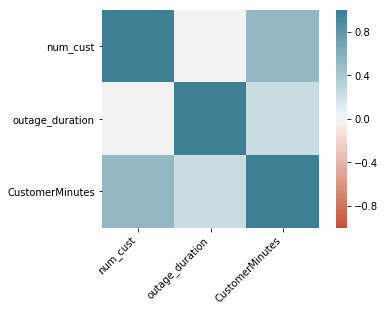

In [38]:
#see how much correlation there is between the numberic variables
corr = wps_outages[wps_num_var].corr()
ax = sns.heatmap(corr, 
                vmin=-1, vmax=1, center=0,
                cmap=sns.diverging_palette(20, 220, n=200),
                square=True)

ax.set_xticklabels(ax.get_xticklabels(),
                    rotation=45,
                    horizontalalignment='right')

In [39]:
#normilize all numeric data
wps_outages_num = wps_outages[wps_num_var]

mean = wps_outages_num.mean(axis=0)
std = wps_outages_num.std(axis=0)

wps_outages_num = (wps_outages_num - mean)/std

In [40]:
#save off mean and std dev for prod cleaning
wps_normalize = pd.DataFrame({'Mean': mean,
                            'Standard Deviation': std})
wps_normalize.to_csv('WPS_normalize.csv', index = False)

In [41]:
#extract outcome variables
wps_outages_out = wps_outages[['outage category', 'outage subcategory']]

In [42]:
#gather all of the data
wps_outages_cleaned = wps_outages_cat.join([wps_outages_num,
                                            wps_outages_date,
                                            wps_outages_out])
#remove missings
wps_outages_cleaned = wps_outages_cleaned.dropna()

wps_outages_cleaned.head()

,State_MI,State_WI,Agency_ANT,Agency_CHI,Agency_ER,Agency_GB,Agency_KEW,Agency_MER,Agency_MIN,Agency_MM,...,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,outage category,outage subcategory
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Public,Foreign Object
1,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,Planned,New Construction
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Public,Fire/Police
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Unknown,
4,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Vegetation,Other


In [43]:
#export cleaned data
wps_outages_cleaned.to_csv('WPS_Cleaned.csv', index = False)